# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

In [1]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'FinalProject')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)
checkpoint_path = os.path.join(HOMEWORK_FOLDER, "params")
os.makedirs(checkpoint_path, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Software installation

The OpenAI Gym library we are will use for the RL simulation environment is installed here.

In [0]:
!pip install gym[all] pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install box2d-py gym[box2d] > /dev/null 2>&1
!pip install visdom > /dev/null 2>&1

# Start a virtual display

A virtual display is needed to communicate with the X server in the backend.

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

# Import Car Racing Environment

Use reinforcement learning to race a car around a track.

Official environment documentation is provided at:

https://gym.openai.com/envs/CarRacing-v0/

From OpenAI:

State consists of 96x96 pixels. Reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles in track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points. Episode finishes when all tiles are visited.


In [0]:
import gym

env = gym.make('CarRacing-v0')
# Uncomment below line for environment documentation
# help(env)

Track generation: 1101..1386 -> 285-tiles track


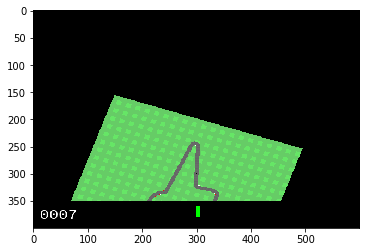

In [5]:
import matplotlib.pyplot as plt

env.reset()
frame = env.render(mode='rgb_array')

plt.imshow(frame)
plt.show()

# Implement Your Solution

For training any models, it will be helpful to save checkpoints and reload from the most recent. This is due to time constraints inside of colab.

While most of the research using these platforms implements model-free reinforcement learning algorithms, you may implement other approaches including model-based methods.

In [0]:
import time
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import visdom
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Hyper-Parameters

In [0]:
class Arguments():
    def __init__(self):
        self.gamma = 0.99
        self.action_repeat = 8
        self.img_stack = 4
        self.seed = 0
        self.render = False
        self.vis = False
        self.log_interval = 10

args = Arguments()

torch.manual_seed(args.seed)
if use_cuda:
    torch.cuda.manual_seed(args.seed)

dtype_vec = np.dtype([('s', np.float64, (args.img_stack, 96, 96)), ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (args.img_stack, 96, 96))])

# Model

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=2,),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.cnn_layer4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.cnn_layer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.cnn_layer6 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.v_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.ReLU()
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.alpha_head = nn.Sequential(
            nn.Linear(128, 3),
            nn.Softplus()
        )
        self.beta_head = nn.Sequential(
            nn.Linear(128, 3),
            nn.Softplus()
        )
        self.apply(self._weights_init)

    def forward(self, x):
        x = self.cnn_layer1(x)
        x = self.cnn_layer2(x)
        x = self.cnn_layer3(x)
        x = self.cnn_layer4(x)
        x = self.cnn_layer5(x)
        x = self.cnn_layer6(x)
        x = x.view(-1, 256)
        v = self.v_head(x)
        alpha = self.alpha_head(self.fc_layer(x)) + 1
        beta = self.beta_head(self.fc_layer(x)) + 1
        return (alpha, beta), v

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

class ACNet(nn.Module):
    """
    Actor-Critic Network for PPO
    """

    def __init__(self):
        super(ACNet, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(args.img_stack, 8, kernel_size=4, stride=2),
            nn.ReLU(),  # activation
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),  # activation
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),  # activation
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),  # activation
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v

# Agent

In [0]:
class AgentTrain():
    def __init__(self, max_norm, epsilon, epochs, num_buffer):
        self.max_norm = max_norm
        self.epsilon = epsilon
        self.epochs = epochs
        self.num_buffer = num_buffer
        self.training_step = 0
        self.acnet = ACNet().type(torch.float64).to(device)
        self.buffer = np.empty(self.num_buffer, dtype=dtype_vec)
        self.counter = 0
        self.optimizer = optim.Adam(self.acnet.parameters(), lr=2e-4)

    def policy(self, state):
        state = torch.from_numpy(state).type(torch.float64).to(device).unsqueeze(0)
        alpha, beta = self.acnet(state)[0]
        distance = Beta(alpha, beta)
        action = distance.sample().squeeze(0)
        log_prob_a = distance.log_prob(action).sum(1)
        action = action.cpu().numpy()
        return action, log_prob_a.item()

    def save_state(self, dtype_vec):
        self.buffer[self.counter] = dtype_vec
        self.counter += 1
        flag = False
        if self.counter >= self.num_buffer:
            self.counter = 0
            flag = True
            return flag

    def update(self):
        self.training_step += 1
        s = torch.tensor(self.buffer['s'], device=device).type(torch.float64)
        a = torch.tensor(self.buffer['a'], device=device).type(torch.float64)
        r = torch.tensor(self.buffer['r'], device=device).type(torch.float64).view(-1, 1)
        s_ = torch.tensor(self.buffer['s_'], device=device).type(torch.float64)
        log_prob_a_old = torch.tensor(self.buffer['log_prob_a'], dtype=torch.double).to(device).view(-1, 1)

        with torch.no_grad():
            v_output = r + 0.99 * self.acnet(s_)[1]
            ad_v = v_output - self.acnet(s)[1]

        for k in range(self.epochs):
            for index in BatchSampler(SubsetRandomSampler(range(self.num_buffer)), 128, False):
                alpha, beta = self.acnet(s[index])[0]
                distance = Beta(alpha, beta)
                log_prob_a = distance.log_prob(a[index]).sum(1, True)
                a_div_old_a = torch.exp(log_prob_a - log_prob_a_old[index])
                obj1 = a_div_old_a * ad_v[index]
                obj2 = torch.clamp(a_div_old_a, 1.0 - self.epsilon, 1.0 + self.epsilon) * ad_v[index]
                action_loss = -torch.min(obj1, obj2).mean()
                value_loss = F.smooth_l1_loss(self.acnet(s[index])[1], v_output[index])
                loss = action_loss + 2 * value_loss
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def get_parameter_number(self):
    
        	total_num = sum(p.numel() for p in self.acnet.parameters())
        	trainable_num = sum(p.numel() for p in self.acnet.parameters() if p.requires_grad)
        	print(self.acnet.state_dict)
        	return total_num, trainable_num



# Train

In [10]:
def reward_memory():
    count = 0
    length = 100
    history = np.zeros(length)

    def memory(reward):
        nonlocal count
        history[count] = reward
        count = (count + 1) % length
        return np.mean(history)

    return memory

def reset(env):
    av_r = reward_memory()
    die = False
    img_rgb = env.reset()
    img_gray = np.dot(img_rgb[..., :], [0.299, 0.587, 0.114])
    img_gray = img_gray / 128. - 1
    stack = [img_gray] * 4
    return stack, av_r, die


def step(env, action, av_r, stack):
    total_reward = 0
    for i in range(8):
        img_rgb, reward, die, _ = env.step(action)
        if die:
            reward += 100   # no penalty for die
        if np.mean(img_rgb[:, :, 1]) > 185.0:   # green penalty
            reward -= 0.05
        total_reward += reward
        done = True if av_r(reward) <= -0.1 else False
        if done or die:
            break
    img_gray = np.dot(img_rgb[..., :], [0.299, 0.587, 0.114])
    img_gray = img_gray / 128. - 1
    stack.pop(0)
    stack.append(img_gray)
    return np.array(stack), total_reward, done, die

agent = AgentTrain(0.5, 0.1, 10, 1000)

# Print the model and parameters
total_num, trainable_num = agent.get_parameter_number()
print("Number of total parameters: ", total_num)
print("Number of trainable parameters: ", trainable_num)

env = gym.make("CarRacing-v0")
env.seed(0)
reward_threshold = env.spec.reward_threshold
stack, _, _ = reset(env)
state = np.array(stack)
training_records = []
running_score = 0
for i_ep in range(2500):
    score = 0
    stack, av_r, die = reset(env)
    state = np.array(stack)
    for t in range(1000):
        action, log_prob_a = agent.policy(state)
        state_, reward, done, die = step(env, action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]), av_r, stack)
        if agent.save_state((state, action, log_prob_a, reward, state_)):
            agent.update()
        score += reward
        state = state_
        if done or die:
            break
    running_score = running_score * 0.99 + score * 0.01

    if i_ep % 10 == 0:
        print('i_ep: {}, score: {}'.format(i_ep, running_score))
        torch.save(agent.acnet.state_dict(), os.path.join(checkpoint_path, 'ppo_net_params_{}.pth'.format(i_ep)))
    if running_score > reward_threshold:
        break


<bound method Module.state_dict of ACNet(
  (cnn_base): Sequential(
    (0): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
  )
  (v): Sequential(
    (0): Linear(in_features=256, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=100, bias=True)
    (1): ReLU()
  )
  (alpha_head): Sequential(
    (0): Linear(in_features=100, out_features=3, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (beta_head): Sequential(
    (0): Linear(in_features=100, out_features=3, bias=

KeyboardInterrupt: ignored